Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

%matplotlib inline

# Stochastic gradient Langevin dynamics, and uncertainty quantification

In this first part of the coursework you'll do two things:

* Implement stochastic gradient Langevin dynamics for sampling from a Bayesian neural network
* Break down the variance to estimate epistemic and aleatoric uncertainty

We're going to run this on the following toy 2D dataset, consisting of **two moons**, each a different class.

C:\Users\benoi\AppData\Local\Temp\ipykernel_7300\2178212526.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset, validation_set = torch.load("two_moons.pt")


(-2.0, 2.0)

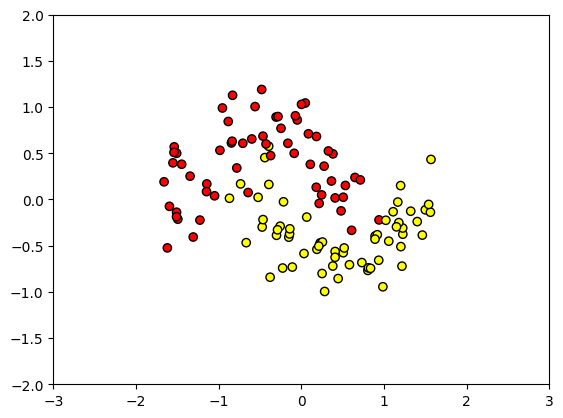

In [36]:
dataset, validation_set = torch.load("two_moons.pt")
X_train, y_train = dataset.tensors
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.xlim(-3,3)
plt.ylim(-2,2)

## We'll use the following simple feedforward network.

In [37]:
class TwoMoonsNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 100),
                        nn.ReLU(), 
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
        
    def forward(self, x):
        h = self.net(x)
        return torch.sigmoid(h).squeeze(1)
    
network = TwoMoonsNetwork()

# TASK 1 (5 points): Define the likelihood and the prior

Let $x_i \in \mathbb{R}^2$ denote an input, $y_i \in \{ 0, 1\}$ a target, and $\theta$ the network parameters.

Let $\hat y_i = f_\theta(x_i)$ denote the output of the network $f_\theta$.

You need to define:

* `log_likelihood`, evaluating a Bernoulli distribution $$\log p(y|x, \theta) = \log \mathrm{Bernoulli}(y | f_\theta(x));$$
* `log_prior`, evaluating a standard normal distribution $$\log p(\theta) = \log \mathcal{N}(\theta | 0, I).$$

Both of these functions should return a numeric scalar value.

For the prior, you will need to somehow access the parameters of the network! There are several ways of doing this. I suggest looking at the pytorch documentation for either

* iterating through `network.parameters()`, or
* using helper functions such as `nn.utils.parameters_to_vector`



In [38]:
def log_likelihood(network, X, y):
    """
    This function computes the log probability `log p(y | x, theta)`
    for a batch of inputs X.
    
    INPUT:
    network : instance of classifier network, extends `nn.Module`
    X       : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y       : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    
    OUTPUT:
    lp      : log probability value of log p(y | x, theta); scalar
    
    """
    # YOUR CODE HERE

    epsilon=10**(-10) #We introduce an espilon for numerical stability
    lp= y*torch.log(torch.abs(network.forward(X)+epsilon)) + (1-y)*torch.log(torch.abs(1-network.forward(X)+epsilon)) #We compute the required log likelihood 
    return lp.sum()


In [39]:
# grading


In [40]:
def log_prior(network):
    """
    This function computes the log probability `log p(theta)`
    
    INPUT:
    network : instance of classifier network, extends `nn.Module`
    
    OUTPUT:
    lpr      : log probability value of log p(theta); scalar
    
    """

    # YOUR CODE HERE
    epsilon=10**(-10) #We introduce an espilon for numerical stability
    theta = nn.utils.parameters_to_vector(network.parameters()) #We obtain out theta by extracting the parameters of our NN
    N = theta.size()[0]
    exponent = -0.5 * (theta @ theta) #We compute our exponent
    log_det_term = -N/2 * torch.log(torch.abs(torch.tensor(2*torch.pi)+epsilon)) #We compute our log det term
    lpr=log_det_term + exponent #We compute our log prior
    return lpr 

In [41]:
# grading


In [42]:
# grading


# TASK 2 (3 points): Minibatching

Minibatching is "trickier" when we have a prior on the network parameters.

The function `log_joint_minibatch` should return a mini-batch estimate of the log joint of the full data, i.e. returning an estimator of $$\log p(\theta) + \sum_{i=1}^N \log p(y_i | x_i, \theta)$$ but which is evaluated on only the specified subset of the $N$ data points.

In [43]:
def log_joint_minibatch(network, X_batch, y_batch, N_training):
    """ Return a minibatch estimate of the full log joint probability 
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set

    OUTPUT:
    lp : return an estimate of log p(y, theta | X), as computed on the batch; scalar.

    """
    # YOUR CODE HERE
    logprior = log_prior(network) #We use our previously defined function to compute our logprior
    M = y_batch.size()[0]
    loglik = log_likelihood(network, X_batch, y_batch) #We use our previously defined function to compute our log likelihood
    lp= N_training/M*loglik+logprior #We compute our log joint minibatch
    return(lp)

In [44]:
# grading


In [45]:
# grading


## Self-diagnostic

This is a small-enough dataset that we can compute the log joint probability on the whole dataset:

In [46]:
with torch.no_grad():
    full_data_lp = log_prior(network) + log_likelihood(network, X_train, y_train)
print("Full data log probability: %0.4f" % full_data_lp.item())

Full data log probability: -1328.3691


### In the next cell, we call `log_joint_minibatch`.

If all the code is working correctly, the minibatch estimates should be roughly normally-distributed around the true value!

Changing the batch size should not change the mean of this distribution. Try running the cell below several times.

If the histogram is far away from the true value (the black vertical dashed line), then you probably have a bug.

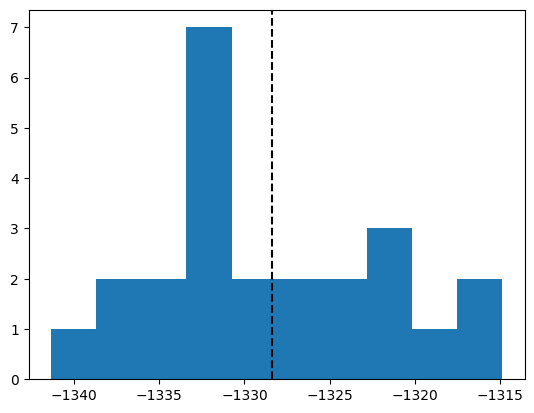

In [47]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)

with torch.no_grad():
    batch_lp_est = [log_joint_minibatch(network, X, y, len(dataset)).item() for X, y in dataloader]
plt.hist(batch_lp_est, bins=10);
yl = plt.ylim()
plt.plot(full_data_lp.item()*np.ones(2), [0, plt.ylim()[1]], 'k--')
plt.ylim(yl);
# torch.stack(batch_lp_est).sum()

## Train the model (MAP estimation)

Run the following cell to train your model, to find a MAP estimate.

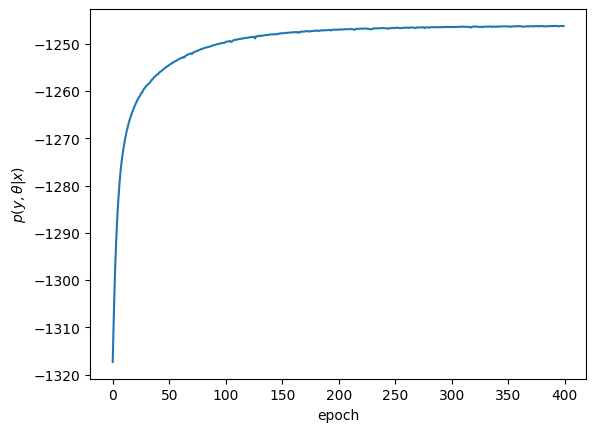

In [48]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)
opt = torch.optim.Adam(network.parameters())

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader:
        opt.zero_grad()
        loss = -log_joint_minibatch(network, X, y, len(dataset))
        loss.backward()
        opt.step()
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item())
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

## Confidence plot

To visualize the result, we'll look at a *confidence plot*.

The *confidence* is the probability assigned to whichever class is predicted.

If the most likely class is "yellow", then it shows $p(y = \text{yellow})$. If the most likely class is red, it shows $p(y = \text{red})$.



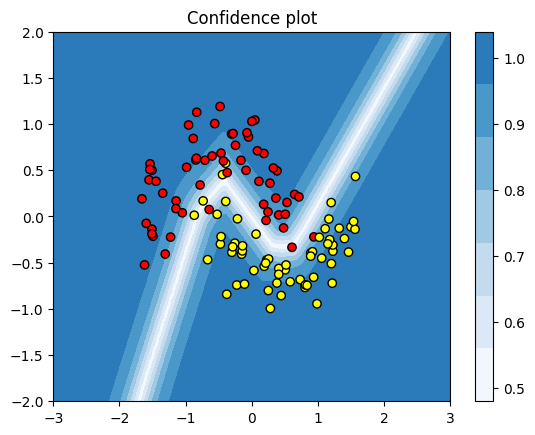

In [49]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    py = network(torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T))
    conf = torch.where(py > 0.5, py, 1-py) ## THIS LINE COMPUTES THE CONFIDENCE
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");

# Calibration and reliability diagrams

I've implemented a reliability diagram plot and expected calibration error computation here.

Could be interesting to see how the number of bins affects the result…!

In [50]:
def reliability_diagram(y, y_hat, N_bins=10):
    """
    Plot a reliability diagram
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    freq = [y[which_bin==k].mean().item() for k in range(N_bins)]
    conf = [y_hat[which_bin==k].mean().item() for k in range(N_bins)]
    plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);
    plt.plot(conf, freq, 'o-', color='k')
    plt.plot([0, 1], [0, 1], '--', color='#333');

def expected_calibration_error(y, y_hat, N_bins=10):
    """
    Compute the expected calibration error
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    counts = []
    acc = []
    conf = []
    for k in range(N_bins):
        count = len(y[which_bin==k])
        if count > 0:
            acc.append(y[which_bin==k].mean().item())
            conf.append(y_hat[which_bin==k].mean().item())
        else:
            acc.append(0.0)
            conf.append(0.0)
        counts.append(count)
    return ((np.abs(np.array(acc) - np.array(conf))*np.array(counts))/len(y)).sum()

ECE = 0.0435


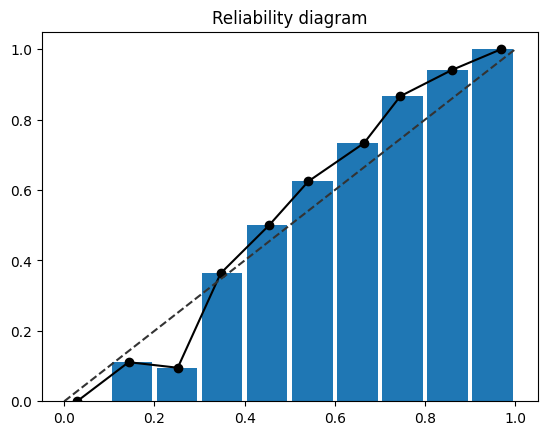

In [51]:
with torch.no_grad():
    y_hat = network(validation_set.tensors[0])

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))
plt.title("Reliability diagram");

# TASK 3 (6 points): stochastic gradient Langevin dynamics (SGLD)

In this task you can get

* 3 points for implementing the SGLD MCMC update
* 3 points for implementing Monte Carlo prediction

The `SGLD_step` function below should take a current set of network parameters $\theta$, and update them as

$$\theta' = \theta + \frac{\epsilon^2}{2} \nabla_\theta \log p(\theta, y | X) + \epsilon z$$

where $\epsilon$ is a learning rate, $X, y$ are a current mini-batch, and $z \sim \mathcal{N}(0, I)$ and has the same dimensionality as $\theta$.

For more details see the week 7 lecture slides!

Note that you will actually have to **do the update**. The following function does not return anything! Instead, it updates the parameters of the network, similar to how a `torch.optim` optimizer updates the parameters.

In [52]:
def SGLD_step(network, X, y, N_training, epsilon):
    """
    Run one step of SGLD given a mini-batch, and update the parameters of the network.
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set
    epsilon    : step size / learning rate parameters (scalar)
    """

    # YOUR CODE HERE
    log_joint = log_joint_minibatch(network, X, y, N_training) #We compute our log joint
    network.zero_grad() #We set gradients to 0
    log_joint.backward() #Back propagation
    theta = nn.utils.parameters_to_vector(network.parameters()) #We compute our theta
    grad = nn.utils.parameters_to_vector([p.grad for p in network.parameters()]) #We compute our gradient
    noise = torch.randn_like(theta) #We compute our noise
    theta_updated = theta + (epsilon**2 / 2) * grad + epsilon * noise #We compute our updated theta
    nn.utils.vector_to_parameters(theta_updated, network.parameters()) #We implement our updated theta in our NN

In [53]:
# grading


In [54]:
# grading


### Cyclic learning rate 

We're going to use a cyclic learning rate schedule for $\epsilon$, like discussed in the lectures. That function is pre-written, below.

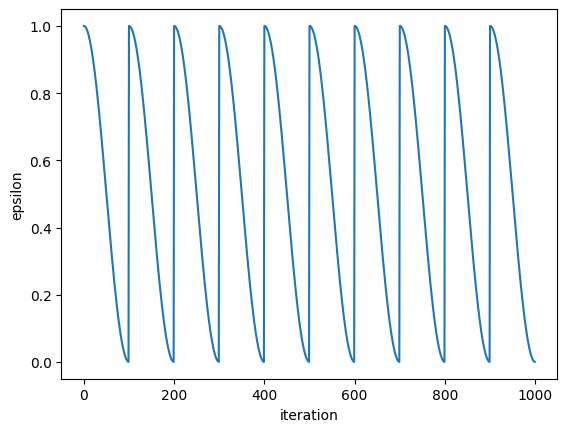

In [55]:
def learning_rate_schedule(N_steps, N_samples, epsilon):
    """
    Pre-compute a learning-rate schedule for SGLD.
    
    INPUT:
    N_steps   : number of SGD updates between each "reset"
    N_samples : number of times we reach the lowest target learning rate
    epsilon   : base learning rate
    
    OUTPUT:
    epsilon_t : vector of length N_steps*N_samples, containing epsilon_t at each iteration t
    """
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)

plt.plot(learning_rate_schedule(N_steps=100, N_samples=10, epsilon=0.5));
plt.xlabel("iteration");
plt.ylabel("epsilon");

### Running the sampler
The following function is also given: it will actually run the SGLD sampler, by calling your `SGLD_step` function above.

In [56]:
def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.02):
    """
    Draw samples using SGLD, following a prescribed learning rate schedule
    
    OUTPUT:
    samples : torch.FloatTensor, shape = (N_samples, "# of parameters in network")
    """
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)


In [57]:
samples = draw_sgld_samples(network, N_samples=50, N_steps_per_sample=200)
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([50, 1321])


## Making predictions

After running the sampler, you now have a `torch.FloatTensor` which contains many different sampled versions of the network parameters $s = 1,\dots,S$.

To make predictions on an input batch $X$, you will somehow need to "load" in the stored parameters, and run the forward pass using different $\theta^{(s)}$.

In [58]:
def predict_from_samples(X, network, samples):
    """
    
    INPUT:
    X       : batch of input points at which to make predictions; shape = (batch_size, 2)
    network : instance of classifier network, extends `nn.Module`
    samples : torch.FloatTensor containing samples of theta; shape = (num_samples, "# of parameters in network")
    
    OUTPUT:
    y_hat_samples : torch.FloatTensor containing samples of y_hat; shape = (num_samples, batch_size)
    """
    # YOUR CODE HERE
    y_hat_samples_list=[]
    for sample in samples :
        nn.utils.vector_to_parameters(sample, network.parameters())
        y_hat_samples_list.append(network.forward(X).detach().numpy())
    return torch.tensor(y_hat_samples_list)

In [59]:
# The following should be true if your code is working!
assert predict_from_samples(X_train, network, samples).shape == (samples.shape[0], X_train.shape[0])

In [60]:
# grading


In [61]:
# grading


## Confidence plot and reliability diagrams for the Bayesian classifier

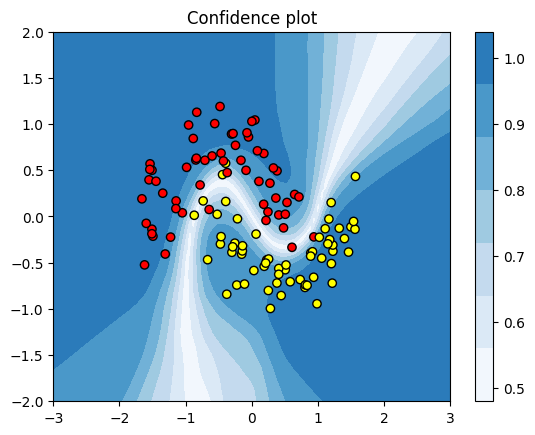

In [62]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    XXYY = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    out = predict_from_samples(XXYY, network, samples)
    py = out.mean(0)
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.title("Confidence plot");

ECE = 0.0484


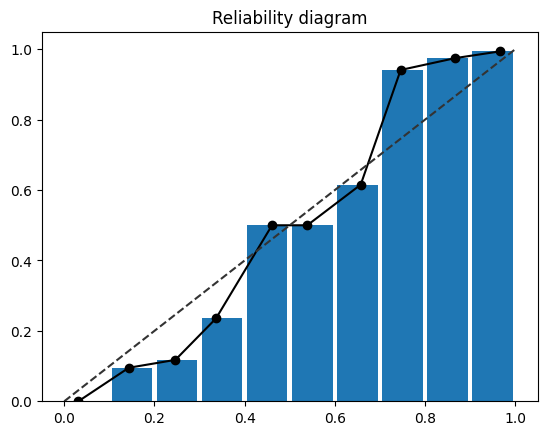

In [63]:
with torch.no_grad():
    y_hat = predict_from_samples(validation_set.tensors[0], network, samples).mean(0)

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))

plt.title("Reliability diagram");

## Uncertainty quantification

We can measure the uncertainty in our predictor by looking at the variance of the predictive distribution

$$p(y | \hat y).$$

Here, $\hat y$ is the posterior mean: the average $p(y = 1)$ estimated across all posterior samples.

The total predictive variance of $y$ is the variance of this distribution, i.e.

$$Var [ y | x ] = Var \left [ \int p(y | x, \theta)p(\theta | \mathcal{D}) d\theta \right]$$

One way to estimate epistemic and aleatoric uncertainty is to look at the variance of $\hat y$, i.e. the variance in $f_\theta(x)$ under the posterior over $\theta$. This corresponds to epistemic uncertainty. The difference between these two is then roughly the aleatoric uncertainty.

There are probably better ways to compute (and explain!) this, but hopefully the following plots look clear.

In [64]:
# Variance of predictive distribution over y
var_of_prediction = dist.Bernoulli(out.mean(0)).variance

# Epistemic uncertainty: Variance across values of y_hat
var_of_mean = out.var(0)



### Darker colors are more uncertain:

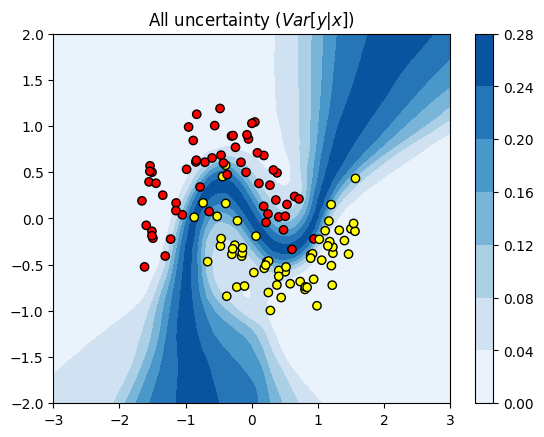

In [65]:
plt.title("All uncertainty ($Var[y | x]$)")
plt.contourf(XX, YY, var_of_prediction.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
# - torch.sigmoid(out).var(0).reshape(XX.shape))

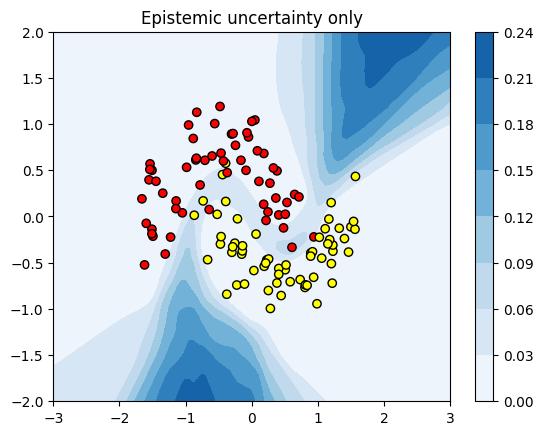

In [66]:
plt.title("Epistemic uncertainty only")
plt.contourf(XX, YY, var_of_mean.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.28)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

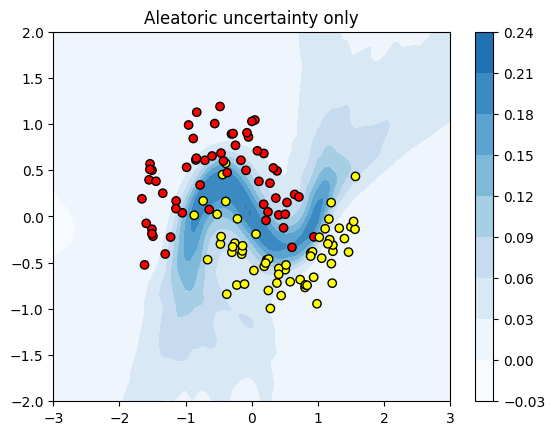

In [67]:
plt.title("Aleatoric uncertainty only")
plt.contourf(XX, YY, (var_of_prediction - var_of_mean).reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

# TASK 4 (up to 5 points, free response): Interpretation

Take a look at Figure 1 in the paper https://arxiv.org/pdf/2002.10118.pdf, "Being Bayesian, Even Just a Bit, Fixes Overconfidence in ReLU Networks", Kristiadi et al. 2020.

1. (4 points) Qualitatively, the uncertainty in figure 1 probably looks quite different from your plots in this notebook. Try to give two different reasons for why the results here might be different.
2. (1 point) What is going on with calibration / temperature scaling? Why doesn't the temperature scaling help in Figure 1 in the paper, and why doesn't the ECE improve in this case when we do sampling?

YOUR ANSWER HERE

1. 

In the given paper, the authors use Laplace approximation to fix overconfidence of neural networks. They implemented a neural network in which all the layers are bayesian, and a second one in which only the last layer is bayesian. Those approaches seem to increase epistemic uncertainty compared to our results, while maintaining high confidence for regions near the training data. On the other hand, we leveraged in this notebook SGLD and take the average of the different prediction results obtained using the different parameters samples. Our approach reduces overconfidence near the decision boundary, but it allows the model to retain certainty for points distant from the training data. We can nevertheless mention that, when we are far from the training data (top roght and bottom left of our graph), our model is less confident.

We can explain the observed differences by two reasons : 

First : The randomness in SGLD can lead to sampling parameter regions with relatively low predictive performance, increasing uncertainty for in-distribution data. Moreover, for computational reasons, we only use 50 samples in our implementation which may not be sufficient to capture the posterior distribution or parameter uncertainty properly. Conversely, Laplace approximation leverages covariance matrix  to capture parameter uncertainty, which gives a more reliable predictive uncertainty. This difference might explain the fact that we have less epistemic uncertainty on our model, compared to the ones presented in the paper.

Second : Laplace approximation captures the parameter posterior as a Gaussian distribution, enabling it to explore broader parameter space and to represent more complex decision boundaries. This includes complex decision boundaries closely encircling specific data clusters, which correspond to what we can see on Figure 1 of the paper. We can notice that, in the paper, the example in which all the layers are Bayesians have a more complex decision boundary than the one which only have the last layer bayesian : it comes from the fact that this model is capable of reaching more parameters when all of his layers are Bayesians. The method we use in this notebook (SGLD + averaging) is not as efficient to estimate complex decision boundaries because the wideness of the space it explores is more dependant on the parameters we choose : to improve the efficiency of our model, we could try to tune its parameters (step size, etc.).

2. 

In the paper, the temperature value is set to a be smaller than 1. This amplifies the overconfidence issue by increasing the predicted probability for the most probable class while reducing it for the other class. The overconfidence of the network is structurally due to other factors (choice of prior, structuration of the network, etc.), which is why temperature scaling isn't helping here to reduce overconfidence.

Doing posterior sampling (like SGLD) with a structurally overconfident model might not improve ECE, as the drawn samples will not represent an accurate posterior.
 